In [63]:
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.modules.loss import BCEWithLogitsLoss

In [64]:
train_dataset_path = r'C:\Users\mdabd\workspace\Adult & Child Classification\training'
test_dataset_path = r'C:\Users\mdabd\workspace\Adult & Child Classification\testing'

mean = [0.5975, 0.4576, 0.3918]
std = [0.2177, 0.1941, 0.1850]

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

In [65]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([0, 0, 0, 1, 0, 1])


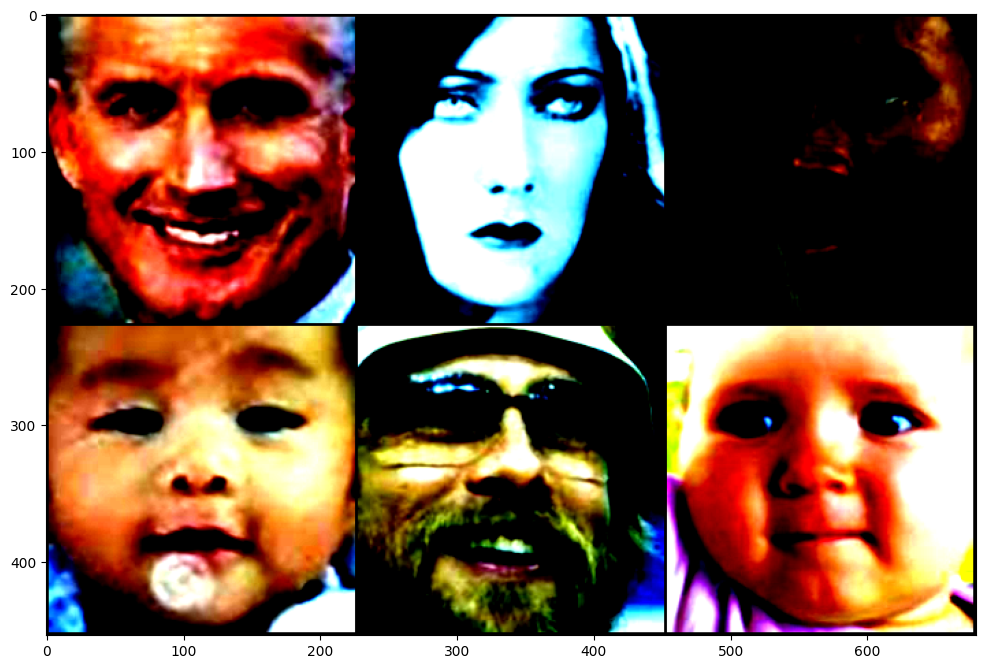

In [66]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels', labels)

show_transformed_images(test_dataset)

In [67]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, shuffle= False)

In [68]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)
set_device()

device(type='cuda', index=0)

In [69]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    for epoch in range(n_epochs):
        print(f"Epoch number {epoch}")
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(f"Training : {running_correct}/{total} -- accuracy {epoch_acc} -- loss {epoch_loss}")

        test_dataset_acc = evaluate_model_test_data(model, test_loader)
        
        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)

    print("Finished")

    return model

In [70]:
def evaluate_model_test_data(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            output = model(images)
            _,predicted = torch.max(output.data, 1)
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print(f"Testing : {predicted_correctly_on_epoch}/{total} -- accuracy {epoch_acc} ")
    return epoch_acc
    

In [71]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch + 1,
        'mode': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'comments': 'very cool model!',
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')
    

In [72]:
resnet18_model = models.resnet18(pretrained=False)
num_ftrs = resnet18_model.fc.in_features
number_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = BCEWithLogitsLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.3)

train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 3)

Epoch number 0


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))

In [ ]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')
print(checkpoint['epoch'])
print(checkpoint['comments'])
print(checkpoint['best_accuracy'])

1
very cool model!
80.42121684867395


In [ ]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_classes)
resnet18_model.load_state_dict(checkpoint['mode'])

torch.save(resnet18_model, 'best_model.pth')

In [ ]:
#train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 50)